In [1]:
using LinearAlgebra, Test, SparseArrays, Plots, Parameters, OffsetArrays, DifferentialEquations, IterativeSolvers, LinearMaps
using DiffEqOperators
using Plots, BenchmarkTools
using Perla1

In [2]:
# parameters for transition (change two to three/four if you want)
params = params_transition_default_two_cohorts();

In [3]:
T = 80.0;
f_0 = [1.0; fill(0.0, set_size(params)-1)];

# Solve information dynamics

In [4]:
# define the corresponding operator
transition_operator! = get_transition_operator(transition_operator_base!, params);

In [5]:
# solve the corresponding ODE
sol_awareness_matrix_free = solve_transition_dynamics(transition_operator!, params, f_0, T);

## Plot

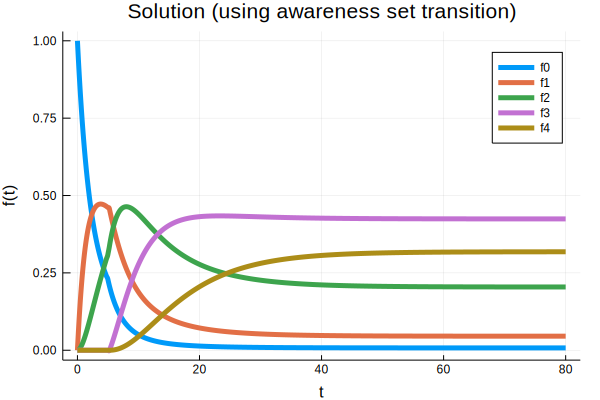

In [6]:
N = params.cohorts[1] # assume that N_t is invariant across all t
K = length(params.cohorts) # number of cohorts

# convert to the counting solution
indices = CartesianIndices(reshape(1:set_size(params), Tuple(fill(0:N, K))))
counts = (x -> sum(indices[x])).(1:set_size(params)) # index to count size
fn_awareness_matrix_free = (n -> (a -> sum(sol_awareness_matrix_free(a)[counts .== n]))).(0:sum(params.cohorts))

# plot
plot(0:0.01:T, fn_awareness_matrix_free,linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=string.("f",0:sum(params.cohorts)))

## Find stationary distribution

  25.664 μs (559 allocations: 23.05 KiB)


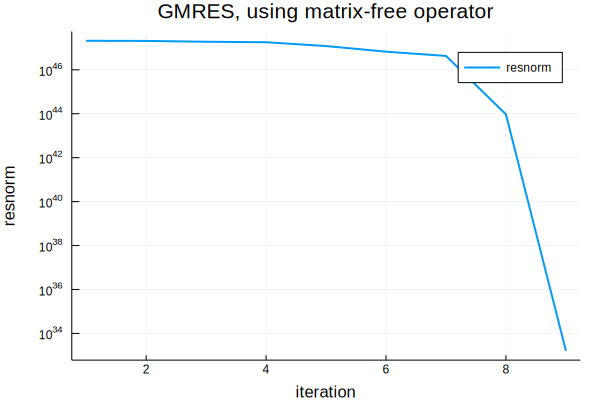

In [7]:
map_matfree! = LinearMap((y,x) -> transition_operator_base!(y, x, params, T), length(f_0); ismutating=true)
stationary, history = @btime gmres!(fill(1/length(f_0), length(f_0)), map_matfree!, similar(f_0), log = true)
stationary /= sum(stationary) # normalize
plot(history, yscale = :log10,linewidth=2,
    title="GMRES, using matrix-free operator",
    xaxis="iteration",yaxis="resnorm")

In [8]:
@test stationary ≈ sol_awareness_matrix_free(T) atol=1e-3

Test Passed